In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time as timing
import os
#from Edited_Photons_for_any_TTBIN import Photons
import random
import math
from numba import jit
from scipy.stats import poisson
from scipy.optimize import curve_fit

def coherence_length(wavelength_nm, delta_lambda_nm):
    # Convert wavelength from nm to meters
    wavelength_m = wavelength_nm * 1e-9
    
    # Convert delta_lambda from nm to meters
    delta_lambda_m = delta_lambda_nm * 1e-9
    
    # Calculate coherence length
    coherence_length_m = (wavelength_m ** 2) / (np.pi * delta_lambda_m)
    
    # Convert coherence length from meters to nm
    coherence_length_nm = coherence_length_m * 1e9
    
    return coherence_length_nm


def calculate_histograms(arrival_times):
    all_histograms = np.zeros((10,))  # Initialize an array to accumulate histograms
    for i, arrival_time in enumerate(arrival_times):
        time_differences = np.abs(arrival_times - arrival_time)  # Calculate time differences
        histogram, _ = np.histogram(time_differences, bins=10, range=(0, np.max(time_differences)))
        all_histograms += histogram  # Accumulate histograms
    return all_histograms

#this function assigns photons to channels the arrival time array has been created 
@jit(nopython=True)
def process_photon_arr(photon_arr, p1, random_number, buffer_size):
    photon_number = photon_arr.shape[0]
    for buffer in range(1, int(photon_number / buffer_size) + 1):
        upper_index = buffer * buffer_size
        lower_index = (buffer - 1) * buffer_size

        temp_arr = p1[lower_index:upper_index].reshape(-1, 1)

        mask = random_number[lower_index:upper_index] > temp_arr

        temp_photon_arr = photon_arr[lower_index:upper_index]
        mask = np.squeeze(mask)

        temp_photon_arr[mask, 0] = 2
        photon_arr[lower_index:upper_index] = temp_photon_arr

    return photon_arr

#this function will assign frequencies to photons given two specific frequencies
@jit
def assign_freq_for_binaryfreq(photon_number,sequence_length, ensamble_size, freq_array,top_freq, bot_freq):
    for j in range(0,photon_number,int(sequence_length)):
        binomial_number = np.random.binomial( ensamble_size, .5, size=1)
        index0 = j
        index1 = int(j+sequence_length)
        
        prob = binomial_number/ ensamble_size
    
        for k in range(len(freq_array[index0:index1])):
            #change every other value to be 600 or 650c
            random_number = random.uniform(0,1)
         
            if random_number > prob:
                freq_array[index0+k] = bot_freq
            else:
                freq_array[index0+k] = top_freq
'''Old assignment function'''
def assign_gaussian_frequency_old(photon_number, sequence_length, ensamble_size, freq_array, top_freq ,bot_freq, std_dev):
    for j in range(0,photon_number,int(sequence_length)):
        index0 = j
        index1 = int(j+sequence_length)
        binomial_number = np.random.binomial( ensamble_size, .5, size=1)
        prob = binomial_number/ ensamble_size
        
        
        random_number = random.uniform(0,1)
      
        if random_number > prob:
            freq_array[index0:index1] = np.random.normal(top_freq, std_dev, size=int(sequence_length))
        else:
            freq_array[index0:index1] = np.random.normal(bot_freq, std_dev, size=int(sequence_length))
            


@jit
def assign_gaussian_frequency(photon_number, sequence_length, ensemble_size, freq_array, top_freq, bot_freq, std_dev):
    for j in range(0, photon_number - sequence_length + 1, sequence_length):
        index0 = j
        index1 = j + sequence_length
        binomial_number = np.random.binomial(ensemble_size, 0.5, size=1)
        prob = binomial_number / ensemble_size
        random_number = random.uniform(0, 1)
        if random_number > prob:
            freq_array[index0:index1] = np.random.normal(top_freq, std_dev, size=sequence_length)
        else:
            freq_array[index0:index1] = np.random.normal(bot_freq, std_dev, size=sequence_length)
    
    # Handle remaining photons
    remaining_photons = photon_number % sequence_length
    if remaining_photons > 0:
        index0 = photon_number - remaining_photons
        index1 = photon_number
        binomial_number = np.random.binomial(ensemble_size, 0.5, size=1)
        prob = binomial_number / ensemble_size
        random_number = random.uniform(0, 1)
        if random_number > prob:
            freq_array[index0:index1] = np.random.normal(top_freq, std_dev, size=remaining_photons)
        else:
            freq_array[index0:index1] = np.random.normal(bot_freq, std_dev, size=remaining_photons)


def assign_gaussian_frequency_v2(sequence_length, total_time, time_array, photon_number, expected_oscillations):
    time_freq_array = np.random.choice([top_freq, bot_freq], size=int(expected_oscillations))
  
    
    # Compute indices for frequency assignment
    indices = (time_array // (total_time * 1e12 / expected_oscillations)) % len(time_freq_array)
    
    # Use indices to assign frequencies with random noise
    freq_array = np.random.normal(time_freq_array[indices.astype(int)], std_dev)
    
    return freq_array


            

#@jit
def assign_frequency_soft_switching(detector_resolution,probability_per_bin, total_time, time_array, photon_number, expected_oscillations,bottom_freq,top_freq,linewidth, lineshape = 'lorentzian'):
    switching_arr = np.zeros((2,int(expected_oscillations)))
    
    switching_arr[0,:] = np.sort(np.random.uniform(0,total_time*1e12, size=int(expected_oscillations)))
    switching_arr[1,:] = np.random.choice(np.array([top_freq, bottom_freq]), size=int(expected_oscillations))

    indices = np.searchsorted(switching_arr[0, :], time_array, side='right') 
 
    freq_arr = np.zeros(photon_number)
    # Draw from a Gaussian distribution for each center frequency
    for i in range(photon_number):
        # Get the center frequency corresponding to the index
        index = indices[i]
     
        center_frequency = switching_arr[1, index]
        if lineshape == 'gaussian':
            # Draw from a Gaussian distribution with center frequency as mean and be sure that the linewidth parameter is std_dev and not HWHM like for lorentzian
            freq_arr[i] = np.random.normal(center_frequency, linewidth)
        if lineshape == 'lorentzian':
            #or a lorentzian 
            freq_arr[i] = center_frequency + linewidth*np.random.standard_cauchy()
        else: 
            print('================================')
            print('wrong lineshape parameter')
            print('================================')
    return freq_arr



        
'''
these two functions have different perfomances but essentially do the same thing. It is better to use the first with large photon numner usually
and better to use the second with small photon number and or small bin size. I would test them to see what works best for your combination of detector 
resolution and photon number. the second usually works better If you arent at or near the array memory limit for time_arr
'''
#@jit(nopython=True)
def simulate_arrival_time(time_arr, PPS, total_time, detector_resolution, probability_per_bin):
    for i in range(1, PPS * total_time):
        passed_bins = 1
        while time_arr[i] == 0:
            random_number = random.random()

            if probability_per_bin > random_number:
                time_arr[i] = time_arr[i - 1] + passed_bins * detector_resolution
            else:
                passed_bins += 1
                
#@jit(nopython=True)
def simulate_arrival_time_alternate(time_arr, photon_number, total_time, detector_resolution, number_of_bins):
    for i in range(1, photon_number):
        arrival_bin = random.randint(0, int(number_of_bins))
     
        time_arr[i] = arrival_bin*detector_resolution
    time_arr_sorted = np.sort(time_arr)
    return time_arr_sorted

def arrival_time_vectorized(photon_number,total_time):
    time_arr = np.random.uniform(0, total_time*1e12, size=int(photon_number))
    return np.sort(time_arr)

def simulate_arrival_time_gamma(photon_number,probability_per_bin,detector_resolution):
    arrival_times = np.random.gamma(shape=1, scale=1/probability_per_bin, size=int(photon_number))
    arrival_times = np.cumsum(arrival_times) *detector_resolution
    return arrival_times


#writes stage positions in an exponential manner
def exp_spacing_position(number_of_pos, final_pos, stage_position):
    
    x = final_pos**(1/number_of_pos)
    
    for i in range(0,number_of_pos+1):
        new_pos = x**i
        stage_position.append(new_pos)
#writes stage positions in a linear manner
def linear_spacing_position(number_of_pos, final_pos, stage_position):
    x = final_pos/number_of_pos
    for i in range(number_of_pos):
        a = i
        new_pos = x*a
        stage_position.append(new_pos)
        

In [2]:
# Define Gaussian functions f(x) and g(x)
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

def lorenzian(x, x0, gamma, A):
    return A * (gamma / ((x - x0) ** 2 + gamma ** 2) / np.pi)

'''
yet to see if both of these functions work the same in the curve fitting, they should 
'''
#def gaussian(x, A, mu, sigma):
  #  return A * np.exp(-(x - mu)**2 / (2 * sigma**2))


def calculate_convolution_gaussian(top_freq, bot_freq,std_dev, plot = False):
    A = 1
    mu_f = 0
    mu_g = np.abs(top_freq-bot_freq)

    x_min = -5
    x_max = 5
    delta_x = .01
    x_values = np.arange(x_min, x_max, delta_x)

    # Compute the values of f(x) and g(x)
    f_x = gaussian(x_values, A, mu_f, std_dev)
    g_x = gaussian(x_values, A, mu_g, std_dev)
    g_x_neg = gaussian(x_values, A, -1*mu_g, std_dev)
    # Compute the cross-correlation
    cross_corr_result = np.correlate(f_x, f_x, mode='same') * delta_x
    dif_cross_corr_result = np.correlate(f_x, 2*f_x+g_x+g_x_neg, mode='same') * delta_x
    

    popt, pcov = curve_fit(gaussian, x_values, cross_corr_result/max(cross_corr_result), p0=[1, 0, 1])
    dif_popt, dif_pcov = curve_fit(gaussian, x_values, dif_cross_corr_result/max(dif_cross_corr_result), p0=[1, 0, 1])
    
    # Extract parameters of the fitted Gaussian
    A_fit, mu_fit, sigma_fit = popt
    
    dif_A_fit, dif_mu_fit, dif_sigma_fit = dif_popt

    # Compute FWHM
    FWHM1 = 2 * np.sqrt(2 * np.log(2)) * sigma_fit
    dif_FWHM = 2 * np.sqrt(2 * np.log(2)) * dif_sigma_fit

    # Compute standard deviation
    std_deviation1 = sigma_fit
    if plot:
        # Plot the original cross-correlation and the fitted Gaussian
        plt.figure(figsize=(10, 5))
        plt.plot(x_values, cross_corr_result/max(cross_corr_result), label='Cross-correlation', color='blue')
        plt.plot(x_values, dif_cross_corr_result/max(dif_cross_corr_result), label='dif_Cross-correlation', color='purple')
        
        plt.plot(x_values, gaussian(x_values, *popt), label='Fitted Gaussian', color='red', linestyle='--')
        plt.plot(x_values, gaussian(x_values, *dif_popt), label='dif_Fitted Gaussian', color='green', linestyle='--')
        plt.title('Cross-correlation and Fitted Gaussian')
        plt.xlabel('x')
        plt.ylabel('Cross-correlation')
        plt.legend()
        
        plt.show()

        print('% undiffused is',(100*(FWHM1/dif_FWHM)))
    return ((FWHM1/dif_FWHM))
   
def calculate_convolution_lorentzian(top_freq, bot_freq, gamma, plot=False):
    A = 1
    mu_f = 0
    mu_g = np.abs(top_freq - bot_freq)
    print(f'{mu_g}')
    x_min = -5
    x_max = 5
    delta_x = .001
    x_values = np.arange(x_min, x_max, delta_x)
    
    # Compute the values of f(x) and g(x)
    f_x = lorenzian(x_values, mu_f, gamma, A)
    g_x = lorenzian(x_values, mu_g, gamma, A)
    g_x_neg = lorenzian(x_values, -1 * mu_g, gamma, A)
    
    
    # Compute the cross-correlation
    cross_corr_result = np.correlate(f_x, f_x, mode='same') * delta_x
    dif_cross_corr_result = np.correlate(f_x, 2 * f_x + g_x + g_x_neg, mode='same') * delta_x

    popt, pcov = curve_fit(lorenzian, x_values, cross_corr_result / max(cross_corr_result), p0=[0, 1, 1])
    dif_popt, dif_pcov = curve_fit(lorenzian, x_values, dif_cross_corr_result / max(dif_cross_corr_result), p0=[0, 1, 1])
    
    # Extract parameters of the fitted Lorentzian
    x0_fit, gamma_fit, A_fit = popt
    dif_x0_fit, dif_gamma_fit, dif_A_fit = dif_popt

    # Compute FWHM
    FWHM1 = 2 * gamma_fit
    dif_FWHM = 2 * dif_gamma_fit

    if plot:
        # Plot the original cross-correlation and the fitted Lorentzian
        plt.figure(figsize=(10, 5))
        plt.plot(x_values, cross_corr_result / max(cross_corr_result), label='Cross-correlation', color='blue')
        plt.plot(x_values, dif_cross_corr_result / max(dif_cross_corr_result), label='dif_Cross-correlation', color='purple')

        plt.plot(x_values, lorenzian(x_values, *popt), label='Fitted Lorentzian', color='red', linestyle='--')
        plt.plot(x_values, lorenzian(x_values, *dif_popt), label='dif_Fitted Lorentzian', color='green', linestyle='--')
        plt.title('Cross-correlation and Fitted Lorentzian')
        plt.xlabel('x')
        plt.ylabel('Cross-correlation')
        plt.legend()
        plt.xlim(-2,2)
        plt.show()
      
        print('% undiffused is', (100 * (FWHM1 / dif_FWHM)))
    
    return FWHM1 / dif_FWHM
    

def run_simulation(directory, top_freq, bot_freq, std_dev, ensamble_size, photons_per_emitter,total_time ,number_of_pos ,detector_resolution = 1e2,
                   switching_time = 1e8):
    pos_file_name = directory + os.sep +'posFile.pos'
    pcfs_file_name = directory + os.sep +'position.pcfslog'
    pos_file = open(pos_file_name,'w')
    pcfs_log_file = open(pcfs_file_name, 'w')
    PPS = int(ensamble_size*photons_per_emitter)
    expected_oscillations = int(total_time*1e12/switching_time)
    # Calculate coherence length
    coherence_length_result = coherence_length(bot_freq, std_dev)
    print("Coherence Length:", coherence_length_result, "nm") 
    #choose center stage positions in nm as path length differences 
    stage_position = []
    
    final_pos = coherence_length_result #in nm. 1e8 is the largest possible stage pos but dont increase sim beyond 7e5 in practicality
    linear_spacing_position(number_of_pos, final_pos,stage_position)
    
    counter = 0
    for i in stage_position:
        #photon_number = int(PPS*total_time)
        photon_number =int(np.random.poisson(int(PPS*total_time)))

        projected_time_start = timing.time()
        counter +=1
        print(f'stage position {counter} completed')
        file_name = f'pos {int(i)}'
        
          # Calculate probability of finding a photon in a detector bin
        probability_per_bin = (PPS / 1e12) * detector_resolution
        number_of_bins = total_time*1e12/detector_resolution
        start1 = timing.time()
        time_arr = simulate_arrival_time_gamma(photon_number,probability_per_bin,detector_resolution)
        end1 = timing.time()
        print(f'time to simulate arrival times {end1-start1}')


        start4 = timing.time()
        freq_array = assign_frequency_soft_switching(detector_resolution,probability_per_bin, total_time, time_arr, photon_number, expected_oscillations, bot_freq, top_freq, std_dev)
        end4 = timing.time()
        print(f'time to assign freqq {end4-start4}')
        center_stage_position = i
        #amplitude in nm /2 this is from center to peak 
        dither_amplitude = 1200
        #period in  picoseconds
        dither_time_period =int(1e12)
        time_between_stage_steps = 1e6
        
   
        #all data for each photon stored in an array, first column is channel, second is arrival time, fourth is frequency, third is a place holder if the sim will expand to add relative time to a pulse
        photon_arr = np.zeros((photon_number, 4))
        #set the 4th column to be photon color
        photon_arr[:,3]= freq_array
        #set the first column to be channel 1
        photon_arr[:,0] =1
        photon_arr[:,1] = time_arr
        #create dither waveform 
        #make sure the dither period is divisible by 4 to work with nice round numbers
        dither_waveform = np.zeros(int(dither_time_period/time_between_stage_steps))

        dither_waveform[:int(dither_time_period/(4*time_between_stage_steps))] = np.linspace(center_stage_position , dither_amplitude+center_stage_position,int(dither_time_period/(4*time_between_stage_steps)))
        dither_waveform[int(dither_time_period/(4*time_between_stage_steps)):int(3*dither_time_period/(4*time_between_stage_steps))] = np.linspace(dither_amplitude+center_stage_position , center_stage_position-dither_amplitude, int(dither_time_period/(2*time_between_stage_steps)))
        dither_waveform[int(3*dither_time_period/(4*time_between_stage_steps)):] = np.linspace(center_stage_position-dither_amplitude , center_stage_position,  int(dither_time_period/(4*time_between_stage_steps)))
        #Find where we are in the dither given absolute time
        relative_dither_time = photon_arr[:,1] % dither_time_period
        stage_pos = np.zeros(photon_number)
         # Convert relative_dither_time to indices directly
        indices = (relative_dither_time / time_between_stage_steps).astype(int)
        # Use array indexing to assign values to stage_pos
        stage_pos = dither_waveform[indices]
        #based on interference contstruct a probability of going to one detector or the other, this also serves to make the detectors anticorrelated in phase
        p1 = .5 +.5*np.cos(4*np.pi*stage_pos[:]/photon_arr[:,3])
      
        random_number = np.random.rand(photon_number, 1)

        start2 = timing.time()

        # Reshape p1 array to match the shape of random_number
        p1_reshaped = p1.reshape(-1, 1)

        # Use vectorized comparison to create mask
        mask = random_number > p1_reshaped

        # Convert mask to boolean array
        mask = np.squeeze(mask)

        # Modify photon_arr in-place using boolean indexing
        photon_arr[mask, 0] = 2

        end2 = timing.time()
        print(f'time to make photons array {end2 - start2}')

        #write positions to file as nm
        value = str(i*1e-6)

        pos_file.write(value + "\n")
        pcfs_log_file.write(value + "\n")
        
        photons_mimic = photon_arr[:,:2]
        photons_mimic = photons_mimic.flatten()
        
        #write photons file in binary
        fout = open(directory +os.sep + file_name + '.photons', 'wb')
        
        photons_mimic.astype(np.uint64).tofile(fout)
        fout.close()
        
        projected_time_end = timing.time()
        total_for_one_loop = projected_time_end - projected_time_start
        total_time_proj = total_for_one_loop * number_of_pos
        time_left = total_time_proj - total_for_one_loop*counter
        print(f'total time to complete is {int(total_time_proj/60)}mins and the total time left is {int(time_left/60)}mins')
        
        
        
    pos_file.close() 
    pcfs_log_file.close()
    
def convert_wn_to_wl(reighliegh_wavelength,raman_wavenumber,linewidth_cm, freq_jump_cm):
    raman_wavelength = 1e7/(1e7/reighliegh_wavelength-raman_wavenumber)
    #cm -1 to nm conversion 
    #for single conversion s

    raman_wavelength = 1e7/(1e7/reighliegh_wavelength-raman_wavenumber)

    #compute the nm shift for inverse cm shifts
    center_peak1 = raman_wavenumber
    upper_end1 = center_peak1+linewidth_cm/2
    lower_end1 = center_peak1-linewidth_cm/2
    upper_nm1 = 1e7/(1e7/reighliegh_wavelength-upper_end1)
    lower_nm1= 1e7/(1e7/reighliegh_wavelength-lower_end1)

    #linewidth in nm 
    linewidth_nm = (upper_nm1-lower_nm1)/2

    #compute the nm shift for inverse cm shifts
 
    center_peak = raman_wavenumber
    upper_end = center_peak+freq_jump_cm
    lower_end = center_peak
    upper_nm = 1e7/(1e7/reighliegh_wavelength-upper_end)
    lower_nm = 1e7/(1e7/reighliegh_wavelength-lower_end)

    #linewidth in nm 
    nm_shift = upper_nm-lower_nm

    return (raman_wavelength, nm_shift, linewidth_nm)

raman_wavelength, shift, linewidth = convert_wn_to_wl(reighliegh_wavelength = 633,raman_wavenumber = 810 ,linewidth_cm = 1.5, freq_jump_cm = 3)

In [3]:

%run jupyter_photons_code_FI.ipynb   
%run jupyter_pcfs_code_FI.ipynb

primary_directory = '/global/scratch/projects/co_utzatgroup/ccobbbruno/24_11_01/'



ensamble_size = 1
#photons per emitter per second
photons_per_emitter =1e5
# Define time of simulation in s
total_time =int(10)
detector_resolution = 1e2
#the number of cycles you expect the frequency to go through in ps
switching_time = 1e9
number_of_pos = 30

raman_wavelength, shift, linewidth = convert_wn_to_wl(reighliegh_wavelength = 633, raman_wavenumber = 810 ,linewidth_cm = 4, freq_jump_cm = 6)
dif_array = [shift]

collective_fwhm_arr = []
std_dev = linewidth
top_freq = raman_wavelength
print(dif_array,std_dev)
pcfs_instances = {}
for dif in dif_array:
    directory = os.path.join(primary_directory, f'{dif:.2f}nm_wavelength_difference')
    
    # Check if the directory already exists
    if not os.path.exists(directory):
        # If not, create the directory
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")
        
    
    bot_freq = float(raman_wavelength + dif)
    
    run_simulation(directory, top_freq, bot_freq, std_dev, ensamble_size, photons_per_emitter,total_time ,50)
    
    pcfs_instance_name = f"pcfs_{dif:.2f}"
    pcfs_instances[pcfs_instance_name] = PCFS(directory, 2, simulation=True)
    pcfs_instances[pcfs_instance_name].get_intensity_correlations((1e1, 1e11), 3)
    pcfs_instances[pcfs_instance_name].get_blinking_corrected_PCFS()
    pcfs_instances[pcfs_instance_name].get_splev_mirror_spec_corr(0, 0, fit_interferogram = True)
    pcfs_instances[pcfs_instance_name].plot_spectral_diffusion([1e2, 1e6, 1e9], -4)
    pcfs_instances[pcfs_instance_name].plot_splev_spec_corr([1e7, 1e9], (-2.5, 2.5))
    for i,tau in enumerate(pcfs_instances[pcfs_instance_name].tau):
        plt.plot(pcfs_instances[pcfs_instance_name].blinking_corrected_PCFS_interferogram[i, :])
        plt.show()
        
    calculate_convolution_lorentzian(top_freq, bot_freq,std_dev, plot = True)

    fwhm_arr = []
    for i in range(len(pcfs_instances[pcfs_instance_name].tau)):
        y = pcfs_instances[pcfs_instance_name].splev_spec_corr['spectral_corr'][i,:]/max(pcfs_instances[pcfs_instance_name].splev_spec_corr['spectral_corr'][i,:])
        x = pcfs_instances[pcfs_instance_name].splev_spec_corr['zeta']
        try:
            params, covariance = curve_fit(lorenzian, x, y)
        except RuntimeError:
            fwhm_arr.append(0)
        else:
            #for lorenzian
            fwhm = 2 * params[1] 
            #for gaussian
            #fwhm = 2 * np.sqrt(2 * np.log(2)) * params[2]
            fwhm_arr.append(fwhm)
            #plt.plot(x, y, 'bo', label='Data')
            #plt.plot(x, lorenzian(x, *params), 'r-', label='Fit')
            #plt.legend()

           # plt.show()

    plt.scatter(pcfs_instances[pcfs_instance_name].tau,fwhm_arr, label='Scatter Plot on Log Scales')
    plt.xscale('log')
    #plt.xlim(1e4,1e11)
    #plt.ylim(.5,1.1)
    plt.show()
    
    print(bot_freq)
    print(top_freq)
    total_end = timing.time()
    #print(f'total run time: {total_end-total_start}')
    collective_fwhm_arr.append(fwhm_arr)


[0.26720836133210923] 0.08903379855257754
Directory already exists: /global/scratch/projects/co_utzatgroup/ccobbbruno/24_11_01/0.27nm_wavelength_difference
Coherence Length: 1592824.445103439 nm
stage position 1 completed
time to simulate arrival times 0.04302501678466797
time to assign freqq 0.7942619323730469
time to make photons array 0.010857105255126953
total time to complete is 0mins and the total time left is 0mins
stage position 2 completed
time to simulate arrival times 0.04060053825378418
time to assign freqq 0.7907493114471436
time to make photons array 0.01063847541809082
total time to complete is 0mins and the total time left is 0mins
stage position 3 completed
time to simulate arrival times 0.03863978385925293
time to assign freqq 0.7848989963531494
time to make photons array 0.010582447052001953
total time to complete is 0mins and the total time left is 0mins
stage position 4 completed
time to simulate arrival times 0.04001426696777344
time to assign freqq 0.795647382736

IndexError: index 100000 is out of bounds for axis 1 with size 100000

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Generate x values for the first subplot
x = np.linspace(pcfs_instances[pcfs_instance_name].mirror_stage_positions[0], 
                pcfs_instances[pcfs_instance_name].mirror_stage_positions[-1], 
                len(pcfs_instances[pcfs_instance_name].mirror_PCFS_interferogram[1, :]))

# First subplot
for i, tau in enumerate(pcfs_instances[pcfs_instance_name].tau):
    if 40 < i <50 and i % 2 == 0:
        axs[0].plot(x, 
                    pcfs_instances[pcfs_instance_name].mirror_PCFS_interferogram[i, :] / max(pcfs_instances[pcfs_instance_name].mirror_PCFS_interferogram[i, :]), 
                    label=f'tau = {pcfs_instances[pcfs_instance_name].tau[i] / 1e6} us')
axs[0].set_xlabel('mm')
axs[0].set_ylabel('Normalized Interferogram')
axs[0].legend()
axs[0].set_title('Fitted PCFS Interferogram')

# Second subplot
for i, tau in enumerate(pcfs_instances[pcfs_instance_name].tau):
    if 40 < i < 50 and i % 2 == 0:
        axs[1].plot(pcfs_instances[pcfs_instance_name].stage_positions, 
                    pcfs_instances[pcfs_instance_name].blinking_corrected_PCFS_interferogram[i, :], 
                    label=f'tau = {pcfs_instances[pcfs_instance_name].tau[i] / 1e6} us')
axs[1].set_xlabel('mm')
axs[1].set_ylabel('Blinking Corrected Interferogram')
axs[1].legend()
axs[1].set_title('Blinking Corrected PCFS Interferogram')


# Second subplot
for i, tau in enumerate(pcfs_instances[pcfs_instance_name].tau):
    if 40 < i < 50 and i % 2 == 0:
        axs[2].plot(pcfs_instances[pcfs_instance_name].splev_spec_corr['zeta'], 
                    pcfs_instances[pcfs_instance_name].splev_spec_corr['spectral_corr'][i, :]/max(pcfs_instances[pcfs_instance_name].splev_spec_corr['spectral_corr'][i, :]), 
                    label=f'tau = {pcfs_instances[pcfs_instance_name].tau[i] / 1e6} us')
axs[2].set_xlabel('meV')
axs[2].set_ylabel('spectral corrleation')
axs[2].set_xlim(-1,1)
axs[2].legend()
axs[2].set_title('spectral correlation')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

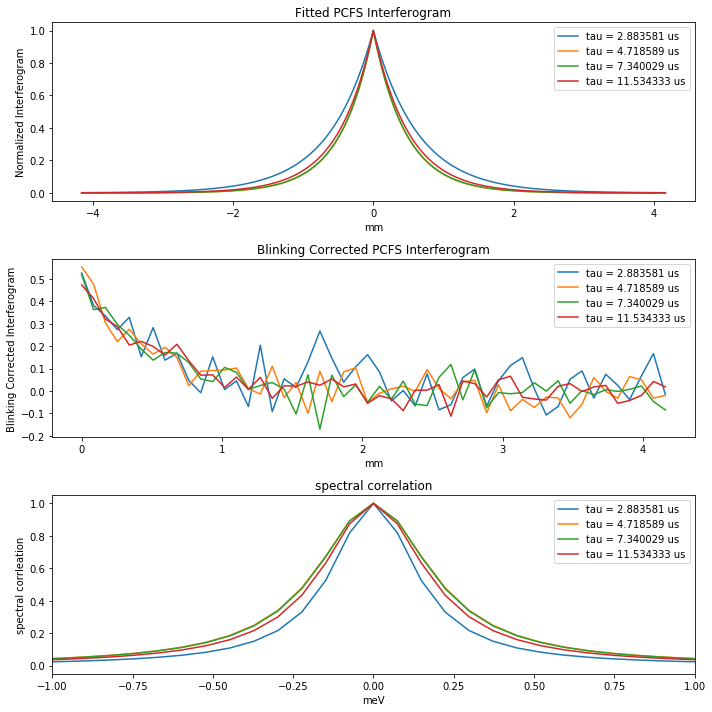

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Generate x values for the first subplot
x = np.linspace(pcfs_instances[pcfs_instance_name].mirror_stage_positions[0], 
                pcfs_instances[pcfs_instance_name].mirror_stage_positions[-1], 
                len(pcfs_instances[pcfs_instance_name].mirror_PCFS_interferogram[1, :]))

# First subplot
for i, tau in enumerate(pcfs_instances[pcfs_instance_name].tau):
    if 50 < i < 60 and i % 2 == 0:
        axs[0].plot(x, 
                    pcfs_instances[pcfs_instance_name].mirror_PCFS_interferogram[i, :] / max(pcfs_instances[pcfs_instance_name].mirror_PCFS_interferogram[i, :]), 
                    label=f'tau = {pcfs_instances[pcfs_instance_name].tau[i] / 1e6} us')
axs[0].set_xlabel('mm')
axs[0].set_ylabel('Normalized Interferogram')
axs[0].legend()
axs[0].set_title('Fitted PCFS Interferogram')

# Second subplot
for i, tau in enumerate(pcfs_instances[pcfs_instance_name].tau):
    if 50 < i < 60 and i % 2 == 0:
        axs[1].plot(pcfs_instances[pcfs_instance_name].stage_positions, 
                    pcfs_instances[pcfs_instance_name].blinking_corrected_PCFS_interferogram[i, :], 
                    label=f'tau = {pcfs_instances[pcfs_instance_name].tau[i] / 1e6} us')
axs[1].set_xlabel('mm')
axs[1].set_ylabel('Blinking Corrected Interferogram')
axs[1].legend()
axs[1].set_title('Blinking Corrected PCFS Interferogram')


# Second subplot
for i, tau in enumerate(pcfs_instances[pcfs_instance_name].tau):
    if 50 < i < 60 and i % 2 == 0:
        axs[2].plot(pcfs_instances[pcfs_instance_name].splev_spec_corr['zeta'], 
                    pcfs_instances[pcfs_instance_name].splev_spec_corr['spectral_corr'][i, :]/max(pcfs_instances[pcfs_instance_name].splev_spec_corr['spectral_corr'][i, :]), 
                    label=f'tau = {pcfs_instances[pcfs_instance_name].tau[i] / 1e6} us')
axs[2].set_xlabel('meV')
axs[2].set_ylabel('spectral corrleation')
axs[2].set_xlim(-1,1)
axs[2].legend()
axs[2].set_title('spectral correlation')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

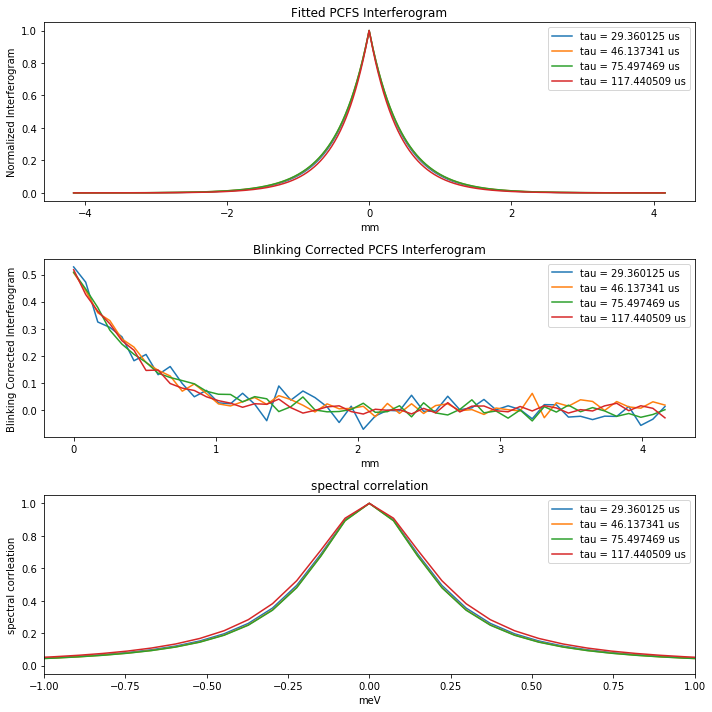

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Generate x values for the first subplot
x = np.linspace(pcfs_instances[pcfs_instance_name].mirror_stage_positions[0], 
                pcfs_instances[pcfs_instance_name].mirror_stage_positions[-1], 
                len(pcfs_instances[pcfs_instance_name].mirror_PCFS_interferogram[1, :]))

# First subplot
for i, tau in enumerate(pcfs_instances[pcfs_instance_name].tau):
    if 60 < i < 70 and i % 2 == 0:
        axs[0].plot(x, 
                    pcfs_instances[pcfs_instance_name].mirror_PCFS_interferogram[i, :] / max(pcfs_instances[pcfs_instance_name].mirror_PCFS_interferogram[i, :]), 
                    label=f'tau = {pcfs_instances[pcfs_instance_name].tau[i] / 1e6} us')
axs[0].set_xlabel('mm')
axs[0].set_ylabel('Normalized Interferogram')
axs[0].legend()
axs[0].set_title('Fitted PCFS Interferogram')

# Second subplot
for i, tau in enumerate(pcfs_instances[pcfs_instance_name].tau):
    if 60 < i < 70 and i % 2 == 0:
        axs[1].plot(pcfs_instances[pcfs_instance_name].stage_positions, 
                    pcfs_instances[pcfs_instance_name].blinking_corrected_PCFS_interferogram[i, :], 
                    label=f'tau = {pcfs_instances[pcfs_instance_name].tau[i] / 1e6} us')
axs[1].set_xlabel('mm')
axs[1].set_ylabel('Blinking Corrected Interferogram')
axs[1].legend()
axs[1].set_title('Blinking Corrected PCFS Interferogram')


# Second subplot
for i, tau in enumerate(pcfs_instances[pcfs_instance_name].tau):
    if 60 < i < 70 and i % 2 == 0:
        axs[2].plot(pcfs_instances[pcfs_instance_name].splev_spec_corr['zeta'], 
                    pcfs_instances[pcfs_instance_name].splev_spec_corr['spectral_corr'][i, :]/max(pcfs_instances[pcfs_instance_name].splev_spec_corr['spectral_corr'][i, :]), 
                    label=f'tau = {pcfs_instances[pcfs_instance_name].tau[i] / 1e6} us')
axs[2].set_xlabel('meV')
axs[2].set_ylabel('spectral corrleation')
axs[2].set_xlim(-1,1)
axs[2].legend()
axs[2].set_title('spectral correlation')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


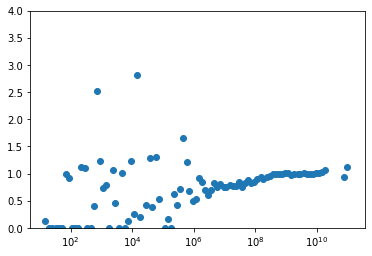

In [6]:

fwhm_norm = fwhm_arr/fwhm_arr[85]


plt.scatter(pcfs_instances[pcfs_instance_name].tau,fwhm_norm, label='Scatter Plot on Log Scales')
plt.xscale('log')
#plt.xlim(1e4,1e11)
plt.ylim(0,4)
plt.show()


In [ ]:
%run jupyter_photons_code_FI.ipynb   
%run jupyter_pcfs_code_FI.ipynb

primary_directory = '/global/scratch/projects/co_utzatgroup/ccobbbruno/24_05_20_fitting_interferogram_test/'



ensamble_size = 1
#photons per emitter per second
photons_per_emitter =1e5
# Define time of simulation in s
total_time =int(1)
detector_resolution = 1e2
#the number of cycles you expect the frequency to go through in ps
switching_time = 1e8
number_of_pos = 50

raman_wavelength, shift, linewidth = convert_wn_to_wl(reighliegh_wavelength = 633, raman_wavenumber = 810 ,linewidth_cm = 1.5, freq_jump_cm = 1.5)
dif_array = [shift]

collective_fwhm_arr = []
std_dev = linewidth
top_freq = raman_wavelength
print(dif_array,std_dev)
pcfs_instances = {}
for dif in dif_array:
    directory = os.path.join(primary_directory, f'{dif:.2f}nm_wavelength_difference')
    
    # Check if the directory already exists
    if not os.path.exists(directory):
        # If not, create the directory
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")
        
    
    bot_freq = float(raman_wavelength + dif)
    
    run_simulation(directory, top_freq, bot_freq, std_dev, ensamble_size, photons_per_emitter,total_time ,50)
    
    pcfs_instance_name = f"pcfs_{dif:.2f}"
    pcfs_instances[pcfs_instance_name] = PCFS(directory, 2, simulation=True)
    pcfs_instances[pcfs_instance_name].get_intensity_correlations((1e1, 1e11), 3)
    pcfs_instances[pcfs_instance_name].get_blinking_corrected_PCFS()
    pcfs_instances[pcfs_instance_name].get_splev_mirror_spec_corr(0, 0, fit_interferogram = False)
    pcfs_instances[pcfs_instance_name].plot_spectral_diffusion([1e2, 1e6, 1e9], -4)
    pcfs_instances[pcfs_instance_name].plot_splev_spec_corr([1e7, 1e9], (-2.5, 2.5))
    for i,tau in enumerate(pcfs_instances[pcfs_instance_name].tau):
        plt.plot(pcfs_instances[pcfs_instance_name].blinking_corrected_PCFS_interferogram[i, :])
        plt.show()
        
    calculate_convolution_lorentzian(top_freq, bot_freq,std_dev, plot = True)

    fwhm_arr = []
    for i in range(len(pcfs_instances[pcfs_instance_name].tau)):
        y = pcfs_instances[pcfs_instance_name].splev_spec_corr['spectral_corr'][i,:]/max(pcfs_instances[pcfs_instance_name].splev_spec_corr['spectral_corr'][i,:])
        x = pcfs_instances[pcfs_instance_name].splev_spec_corr['zeta']
        try:
            params, covariance = curve_fit(lorenzian, x, y)
        except RuntimeError:
            fwhm_arr.append(0)
        else:
            #for lorenzian
            fwhm = 2 * params[1] 
            #for gaussian
            #fwhm = 2 * np.sqrt(2 * np.log(2)) * params[2]
            fwhm_arr.append(fwhm)
            #plt.plot(x, y, 'bo', label='Data')
            #plt.plot(x, lorenzian(x, *params), 'r-', label='Fit')
            #plt.legend()

           # plt.show()

    plt.scatter(pcfs_instances[pcfs_instance_name].tau,fwhm_arr, label='Scatter Plot on Log Scales')
    plt.xscale('log')
    #plt.xlim(1e4,1e11)
    #plt.ylim(.5,1.1)
    plt.show()
    
    print(bot_freq)
    print(top_freq)
    total_end = timing.time()
    #print(f'total run time: {total_end-total_start}')
    collective_fwhm_arr.append(fwhm_arr)


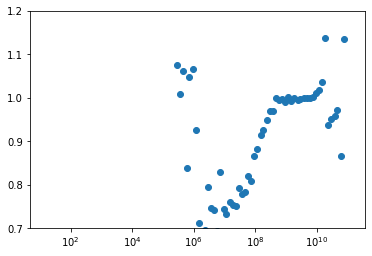

In [16]:
fwhm_norm = fwhm_arr/fwhm_arr[85]


plt.scatter(pcfs_instances[pcfs_instance_name].tau,fwhm_norm, label='Scatter Plot on Log Scales')
plt.xscale('log')
#plt.xlim(1e4,1e11)
plt.ylim(.7,1.2)

plt.show()